In [3]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import itertools
import pandas as pd
from more_itertools import locate
import torch
from torch_geometric.data import Data

def concat_lists(lists):
        return list(itertools.chain.from_iterable(lists))

def pd_to_adj_matrix(df:pd.DataFrame, columns:list, weights:list):
    adj, edgeWeights = np.zeros([2,0]), []
    for i, column in enumerate(columns):
        edgeDest = [list(locate(df[~olumn], lambda x: x==i)) for i in df[column]]
        edgeOrig = concat_lists([list(np.ones(len(x)).astype(int)*i) for i, x in enumerate(edgeDest)])
        edgeDest = concat_lists(edgeDest)
        nonSelf = np.where([val!=edgeDest[i] for i, val in enumerate(edgeOrig)])[0]
        adj = np.concatenate((adj,np.array([np.take(edgeOrig,nonSelf), np.take(edgeDest,nonSelf)])),axis=-1)
        edgeWeights = edgeWeights + [weights[i]]*len(edgeDest)
    return adj.astype(int), edgeWeights

def draw_graph(nodes,edges,edgeWeights,nodeType):
    graph = nx.Graph()
    edges = zip(edges[0], edges[1], edgeWeights)
    graph.add_weighted_edges_from(edges)
    graph.add_nodes_from(nodes)
    pos = nx.kamada_kawai_layout(graph)
    fig, ax = plt.subplots(1,1,figsize=[15,15])
    nx.draw_networkx(graph,pos, with_labels=False,node_size=50,width=0.1, node_color=nodeType, cmap=plt.cm.coolwarm)

In [118]:
class IHSData(object):
    def __init__(self):
        self.productFile = "C:/Users\lukec\OneDrive - University of Cambridge\PhD\Data\IHS\Ethylene\products.csv"
        self.materialFile = "C:/Users\lukec\OneDrive - University of Cambridge\PhD\Data\IHS\Ethylene\materials.csv"
        self.products = pd.read_csv(self.productFile,index_col=0).reset_index(drop=True)
        self.materials = pd.read_csv(self.materialFile,index_col=0).reset_index(drop=True)
        self.edgeColumns = ['Process']
        self.weights = [1]
        self.adjMatrix, self.edgeWeights = pd_to_adj_matrix(self.products,self.edgeColumns,self.weights)
        self.nodeTypes = self.products['Base Capacity (MM unit/year)']
        self.valueColumns = 'Investment (MM US$)'

    def to_pyg_graph(self):
        edge_index = torch.tensor(self.adjMatrix, dtype=torch.long)
        x = torch.tensor([[i] for i in self.products[self.valueColumns]], dtype=torch.float)
        return Data(x=x, edge_index=edge_index)

In [119]:
data = IHSData()

In [120]:
data.products

,Code,Geography,Data Version,Research Year,Process,Unit,Base Capacity (MM unit/year),Investment (MM US$),Type,Name,...,Fixed Costs,"Overhead + Tax, Ins.",Plant Cash Cost,Depreciation,Plant Gate Costs,"G&A, Sales, Res.",Production Cost,ROI (15%),Product Value,Product Price
0,1M-981,"United States, Gulf Coast",2021 Q3,2002.0,ETHYLENE BY THE UOP/HYDRO METHANOL TO OLEFINS ...,KG,400.068470,884.905431,Product,ETHYLENE,...,5.893464,6.625514,34.643831,22.118850,56.762680,2.781679,59.544360,33.178274,92.722634,100.420560
1,2M-981,Germany,2021 Q3,2002.0,ETHYLENE BY THE UOP/HYDRO METHANOL TO OLEFINS ...,KG,400.068470,937.999757,Product,ETHYLENE,...,6.556605,7.251622,90.496201,23.445981,113.942182,4.611685,118.553867,35.168971,153.722838,135.826800
2,3M-981,Japan,2021 Q3,2002.0,ETHYLENE BY THE UOP/HYDRO METHANOL TO OLEFINS ...,KG,400.068470,778.716780,Product,ETHYLENE,...,5.141040,5.321030,106.393440,19.464588,125.858028,4.795513,130.653541,29.196881,159.850422,100.354422
3,4M-981,"China, Shanghai",2021 Q3,2002.0,ETHYLENE BY THE UOP/HYDRO METHANOL TO OLEFINS ...,KG,400.068470,584.037585,Product,ETHYLENE,...,3.742141,3.454213,80.661070,14.598441,95.259511,3.623418,98.882928,21.897661,120.780589,97.532505
4,1M-1595,"United States, Gulf Coast",2021 Q3,2014.0,ETHYLENE FROM 100% ETHANE,KG,1499.998216,2603.121527,Product,ETHYLENE,...,5.280392,5.692002,32.993959,17.354164,50.348123,2.362249,52.710372,26.031246,78.741618,100.420560
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239,4M-1602,"China, Shanghai",2021 Q3,2014.0,METHANOL TO OLEFINS BY THE DMTO-II PROCESS,KG,298.010187,394.934144,Product,ETHYLENE,...,3.570702,3.305171,104.954207,13.252371,118.206578,1.394799,119.601377,19.878556,139.479933,97.532505
240,1M-1603,"United States, Gulf Coast",2021 Q3,2014.0,METHANOL TO OLEFINS BY UOP ADVANCED MTO PROCESS,KG,288.938340,604.837579,Product,ETHYLENE,...,6.383301,6.666587,41.930773,20.933102,62.863875,0.952157,63.816032,31.399653,95.215685,100.420560
241,2M-1603,Germany,2021 Q3,2014.0,METHANOL TO OLEFINS BY UOP ADVANCED MTO PROCESS,KG,288.938340,641.127834,Product,ETHYLENE,...,7.194883,7.383074,104.769784,22.189088,126.958872,1.618611,128.577483,33.283632,161.861116,135.826800
242,3M-1603,Japan,2021 Q3,2014.0,METHANOL TO OLEFINS BY UOP ADVANCED MTO PROCESS,KG,288.938340,532.257070,Product,ETHYLENE,...,5.554709,5.286335,129.071071,18.421130,147.492201,1.768928,149.261130,27.631695,176.892824,100.354422


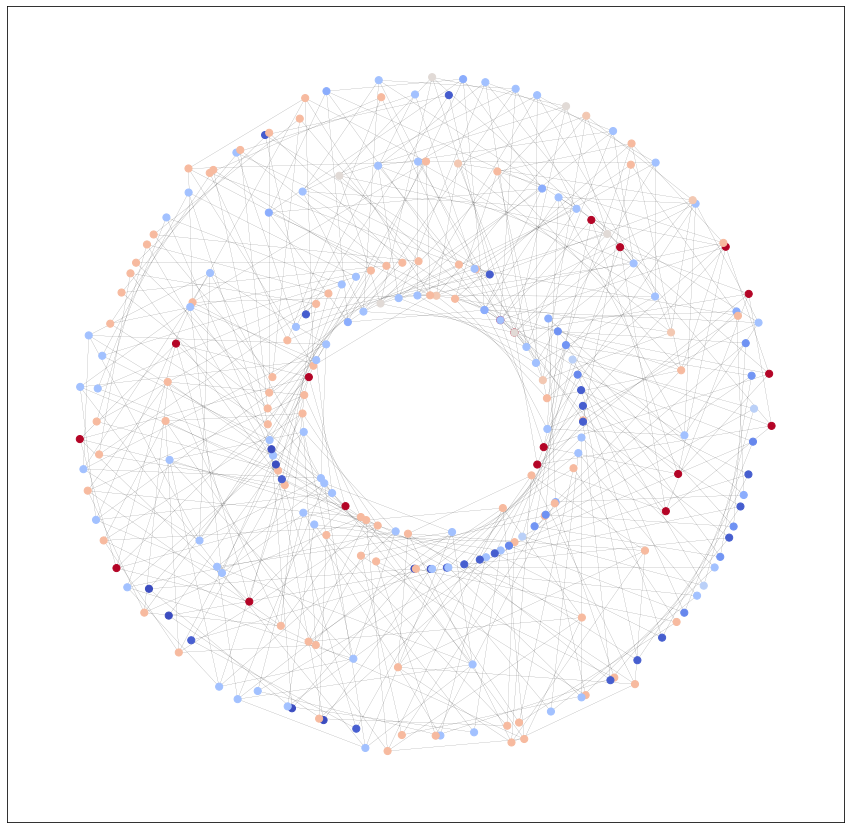

In [121]:
draw_graph(data.products.index,data.adjMatrix,data.edgeWeights,data.nodeTypes)

In [122]:
graph = data.to_pyg_graph()

In [166]:
class SimpleMPStep(MessagePassing):
    def __init__(self, aggr):#in_channels, out_channels):
        super().__init__(aggr=aggr)

    def forward(self, h, edge_index):
        out = self.propagate(edge_index, h=h)#, edge_attr=edge_attr)
        return out

    def message(self, h_i, h_j):#, edge_attr):
        msg = torch.cat([h_i, h_j], dim=-1)
        return msg #self.mlp_msg(msg)

    def aggregate(self, inputs, index):
        return scatter(inputs, index, dim=self.node_dim, reduce=self.aggr)

    def update(self, aggr_out, h):
        upd_out = aggr_out#torch.cat([h, aggr_out], dim=-1)
        return upd_out# self.mlp_upd(upd_out)


In [168]:
prop = SimpleMPStep('mean')
output = prop(graph.x, graph.edge_index)

In [170]:
output

tensor([[ 884.9055,  766.9180],
        [ 937.9998,  749.2200],
        [ 778.7168,  802.3143],
        [ 584.0376,  867.2073],
        [2603.1216, 2634.3589],
        [2759.3088, 2603.1216],
        [2290.7468, 2696.8340],
        [1718.0602, 2811.3716],
        [3384.0581, 2478.1719],
        [3019.6208, 2551.0593],
        [2889.4866, 2924.1606],
        [3062.8560, 2889.4868],
        [2542.7483, 2993.5083],
        [1907.0612, 3120.6458],
        [3756.3328, 2750.7915],
        [3351.8042, 2831.6970],
        [1703.6709, 1724.1149],
        [1805.8910, 1703.6709],
        [1499.2303, 1765.0029],
        [1124.4227, 1839.9645],
        [2214.7722, 1621.8948],
        [1976.2582, 1669.5974],
        [2816.4539, 2440.9268],
        [2985.4412, 2384.5977],
        [2478.4795, 2553.5850],
        [1858.8597, 2760.1250],
        [2856.3391, 2890.6152],
        [3027.7195, 2856.3394],
        [2513.5784, 2959.1675],
        [1885.1838, 3084.8462],
        [3713.2410, 2719.2349],
        

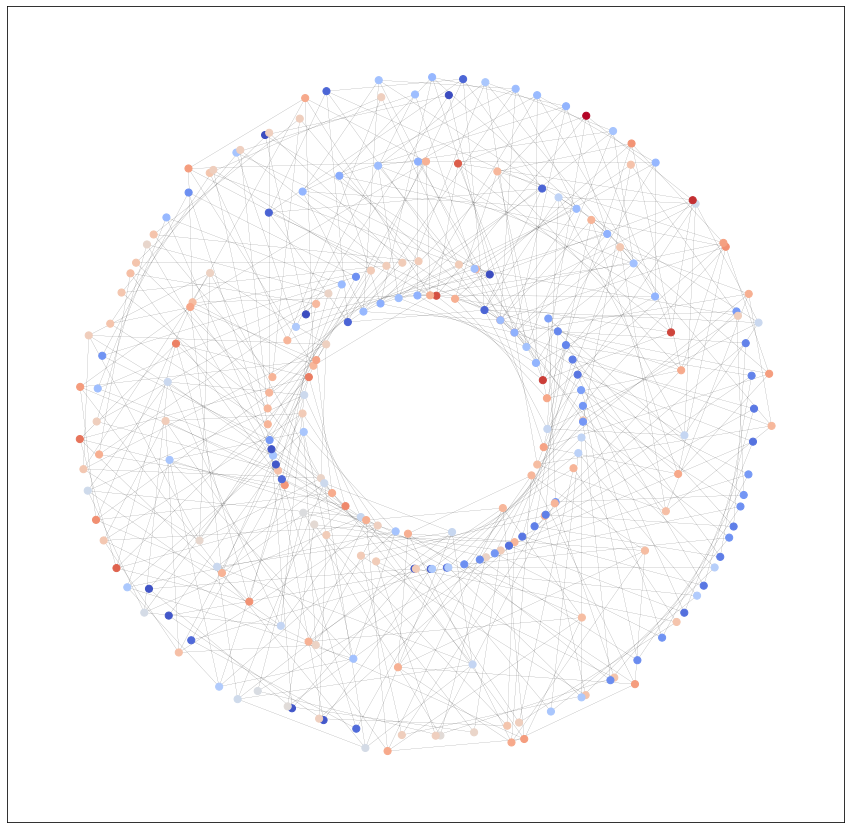

In [169]:
draw_graph(data.products.index,data.adjMatrix,data.edgeWeights,output[:,-1])

In [162]:
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree

class MPStep(MessagePassing):
    def __init__(self, aggr):#in_channels, out_channels):
        super().__init__(aggr=aggr)  # "Add" aggregation (Step 5).
        #self.lin = torch.nn.Linear(in_channels, out_channels)

    # def forward(self, x, edge_index):
    #     # x has shape [N, in_channels]
    #     # edge_index has shape [2, E]
    #
    #     # Step 1: Add self-loops to the adjacency matrix.
    #     #edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))
    #
    #     # Step 2: Linearly transform node feature matrix.
    #     x = x#self.lin(x)
    #
    #     # Step 3: Compute normalization.
    #     # row, col = edge_index
    #     # deg = degree(col, x.size(0), dtype=x.dtype)
    #     # deg_inv_sqrt = deg.pow(-0.5)
    #     # deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0
    #     # norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]
    #
    #     # Step 4-5: Start propagating messages.
    #     return self.propagate(edge_index, x=x)#, norm=norm)
    #
    # # def message(self, x_j, norm):
    # #     # x_j has shape [E, out_channels]
    # #
    # #     # Step 4: Normalize node features.
    # #     return norm.view(-1, 1) * x_j



    def forward(self, h, edge_index):#, edge_attr):
        """
        The forward pass updates node features `h` via one round of message passing.

        As our MPNNLayer class inherits from the PyG MessagePassing parent class,
        we simply need to call the `propagate()` function which starts the
        message passing procedure: `message()` -> `aggregate()` -> `update()`.

        The MessagePassing class handles most of the logic for the implementation.
        To build custom GNNs, we only need to define our own `message()`,
        `aggregate()`, and `update()` functions (defined subsequently).

        Args:
            h: (n, d) - initial node features
            edge_index: (e, 2) - pairs of edges (i, j)
            edge_attr: (e, d_e) - edge features

        Returns:
            out: (n, d) - updated node features
        """
        #edge_index, _ = add_self_loops(edge_index, num_nodes=h.size(0))
        out = self.propagate(edge_index, h=h)#, edge_attr=edge_attr)
        return out

    def message(self, h_i, h_j):#, edge_attr):
        """Step (1) Message

        The `message()` function constructs messages from source nodes j
        to destination nodes i for each edge (i, j) in `edge_index`.

        The arguments can be a bit tricky to understand: `message()` can take
        any arguments that were initially passed to `propagate`. Additionally,
        we can differentiate destination nodes and source nodes by appending
        `_i` or `_j` to the variable name, e.g. for the node features `h`, we
        can use `h_i` and `h_j`.

        This part is critical to understand as the `message()` function
        constructs messages for each edge in the graph. The indexing of the
        original node features `h` (or other node variables) is handled under
        the hood by PyG.

        Args:
            h_i: (e, d) - destination node features
            h_j: (e, d) - source node features
            edge_attr: (e, d_e) - edge features

        Returns:
            msg: (e, d) - messages `m_ij` passed through MLP `\psi`
        """
        msg = torch.cat([h_i, h_j], dim=-1)
        return msg #self.mlp_msg(msg)

    def aggregate(self, inputs, index):
        """Step (2) Aggregate

        The `aggregate` function aggregates the messages from neighboring nodes,
        according to the chosen aggregation function ('sum' by default).

        Args:
            inputs: (e, d) - messages `m_ij` from destination to source nodes
            index: (e, 1) - list of source nodes for each edge/message in `input`

        Returns:
            aggr_out: (n, d) - aggregated messages `m_i`
        """
        return scatter(inputs, index, dim=self.node_dim, reduce=self.aggr)

    def update(self, aggr_out, h):
        """
        Step (3) Update

        The `update()` function computes the final node features by combining the
        aggregated messages with the initial node features.

        `update()` takes the first argument `aggr_out`, the result of `aggregate()`,
        as well as any optional arguments that were initially passed to
        `propagate()`. E.g. in this case, we additionally pass `h`.

        Args:
            aggr_out: (n, d) - aggregated messages `m_i`
            h: (n, d) - initial node features

        Returns:
            upd_out: (n, d) - updated node features passed through MLP `\phi`
        """
        upd_out = aggr_out#torch.cat([h, aggr_out], dim=-1)
        return upd_out# self.mlp_upd(upd_out)

    def __repr__(self) -> str:
        return (f'{self.__class__.__name__}(emb_dim={0}, aggr={self.aggr})')

In [163]:
prop = MPStep('mean')
output = prop(graph.x, graph.edge_index)

In [191]:
class MPModel(Module):
    def __init__(self, num_layers=4):#, emb_dim=64, in_dim=11, edge_dim=4, out_dim=1):
        """Message Passing Neural Network model for graph property prediction

        Args:
            num_layers: (int) - number of message passing layers `L`
            emb_dim: (int) - hidden dimension `d`
            in_dim: (int) - initial node feature dimension `d_n`
            edge_dim: (int) - edge feature dimension `d_e`
            out_dim: (int) - output dimension (fixed to 1)
        """
        super().__init__()

        # Linear projection for initial node features
        # dim: d_n -> d
        #self.lin_in = Linear(in_dim, emb_dim)

        # Stack of MPNN layers
        self.convs = torch.nn.ModuleList()
        for layer in range(num_layers):
            self.convs.append(SimpleMPStep(aggr='mean'))#MPNNLayer(emb_dim, edge_dim, aggr='add'))

        # Global pooling/readout function `R` (mean pooling)
        # PyG handles the underlying logic via `global_mean_pool()`
        #self.pool = global_mean_pool

        # Linear prediction head
        # dim: d -> out_dim
        #self.lin_pred = Linear(emb_dim, out_dim)

    def forward(self, data):
        """
        Args:
            data: (PyG.Data) - batch of PyG graphs

        Returns:
            out: (batch_size, out_dim) - prediction for each graph
        """
        h = data.x #self.lin_in(data.x) # (n, d_n) -> (n, d)

        for conv in self.convs:
            h = h + conv(h, data.edge_index)#, data.edge_attr) # (n, d) -> (n, d)
            # Note that we add a residual connection after each MPNN layer

        #h_graph = self.pool(h, data.batch) # (n, d) -> (batch_size, d)

        out = h#self.lin_pred(h_graph) # (batch_size, d) -> (batch_size, 1)

        return out.view(-1)

In [209]:
from torch import functional
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MPModel().to(device)
data = graph.to(device)
#optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

model.train()
for epoch in range(10):
    optimizer.zero_grad()
    out = model(data)
    loss = functional.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()


model.eval()
pred = model(data).argmax(dim=1)
correct = (pred[data.test_mask] == data.y[data.test_mask]).sum()
acc = int(correct) / int(data.test_mask.sum())
print(f'Accuracy: {acc:.4f}')

RuntimeError: The size of tensor a (2) must match the size of tensor b (4) at non-singleton dimension 1

In [206]:
graph.subgraph(torch.tensor(range(100)))

Data(x=[100, 1], edge_index=[2, 428])

In [207]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(dataset.num_node_features, 16)
        self.conv2 = GCNConv(16, dataset.num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        return F.log_softmax(x, dim=1)

In [173]:
import time
from num
#@title [RUN] Helper functions for managing experiments, training, and evaluating models.

def train(model, train_loader, optimizer, device):
    model.train()
    loss_all = 0

    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        y_pred = model(data)
        loss = F.mse_loss(y_pred, data.y)
        loss.backward()
        loss_all += loss.item() * data.num_graphs
        optimizer.step()
    return loss_all / len(train_loader.dataset)


def eval(model, loader, device):
    model.eval()
    error = 0

    for data in loader:
        data = data.to(device)
        with torch.no_grad():
            y_pred = model(data)
            # Mean Absolute Error using std (computed when preparing data)
            error += (y_pred * std - data.y * std).abs().sum().item()
    return error / len(loader.dataset)


def run_experiment(model, model_name, train_loader, val_loader, test_loader, n_epochs=100):

    print(f"Running experiment for {model_name}, training on {len(train_loader.dataset)} samples for {n_epochs} epochs.")

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    print("\nModel architecture:")
    print(model)
    total_param = 0
    for param in model.parameters():
        total_param += np.prod(list(param.data.size()))
    print(f'Total parameters: {total_param}')
    model = model.to(device)

    # Adam optimizer with LR 1e-3
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # LR scheduler which decays LR when validation metric doesn't improve
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.9, patience=5, min_lr=0.00001)

    print("\nStart training:")
    best_val_error = None
    perf_per_epoch = [] # Track Test/Val MAE vs. epoch (for plotting)
    t = time.time()
    for epoch in range(1, n_epochs+1):
        # Call LR scheduler at start of each epoch
        lr = scheduler.optimizer.param_groups[0]['lr']

        # Train model for one epoch, return avg. training loss
        loss = train(model, train_loader, optimizer, device)

        # Evaluate model on validation set
        val_error = eval(model, val_loader, device)

        if best_val_error is None or val_error <= best_val_error:
            # Evaluate model on test set if validation metric improves
            test_error = eval(model, test_loader, device)
            best_val_error = val_error

        if epoch % 10 == 0:
            # Print and track stats every 10 epochs
            print(f'Epoch: {epoch:03d}, LR: {lr:5f}, Loss: {loss:.7f}, '
                  f'Val MAE: {val_error:.7f}, Test MAE: {test_error:.7f}')

        scheduler.step(val_error)
        perf_per_epoch.append((test_error, val_error, epoch, model_name))

    t = time.time() - t
    train_time = t/60
    print(f"\nDone! Training took {train_time:.2f} mins. Best validation MAE: {best_val_error:.7f}, corresponding test MAE: {test_error:.7f}.")

    return best_val_error, test_error, train_time, perf_per_epoch

In [174]:
model = MPNNModel(num_layers=4, emb_dim=64, in_dim=11, edge_dim=4, out_dim=1)
model_name = type(model).__name__
best_val_error, test_error, train_time, perf_per_epoch = run_experiment(
    model,
    model_name,
    train_loader,
    val_loader,
    test_loader,
    n_epochs=100
)
RESULTS[model_name] = (best_val_error, test_error, train_time)
df_temp = pd.DataFrame(perf_per_epoch, columns=["Test MAE", "Val MAE", "Epoch", "Model"])
DF_RESULTS = DF_RESULTS.append(df_temp, ignore_index=True)

NameError: name 'train_loader' is not defined

In [164]:
output

tensor([[ 884.9055,  766.9180],
        [ 937.9998,  749.2200],
        [ 778.7168,  802.3143],
        [ 584.0376,  867.2073],
        [2603.1216, 2634.3589],
        [2759.3088, 2603.1216],
        [2290.7468, 2696.8340],
        [1718.0602, 2811.3716],
        [3384.0581, 2478.1719],
        [3019.6208, 2551.0593],
        [2889.4866, 2924.1606],
        [3062.8560, 2889.4868],
        [2542.7483, 2993.5083],
        [1907.0612, 3120.6458],
        [3756.3328, 2750.7915],
        [3351.8042, 2831.6970],
        [1703.6709, 1724.1149],
        [1805.8910, 1703.6709],
        [1499.2303, 1765.0029],
        [1124.4227, 1839.9645],
        [2214.7722, 1621.8948],
        [1976.2582, 1669.5974],
        [2816.4539, 2440.9268],
        [2985.4412, 2384.5977],
        [2478.4795, 2553.5850],
        [1858.8597, 2760.1250],
        [2856.3391, 2890.6152],
        [3027.7195, 2856.3394],
        [2513.5784, 2959.1675],
        [1885.1838, 3084.8462],
        [3713.2410, 2719.2349],
        

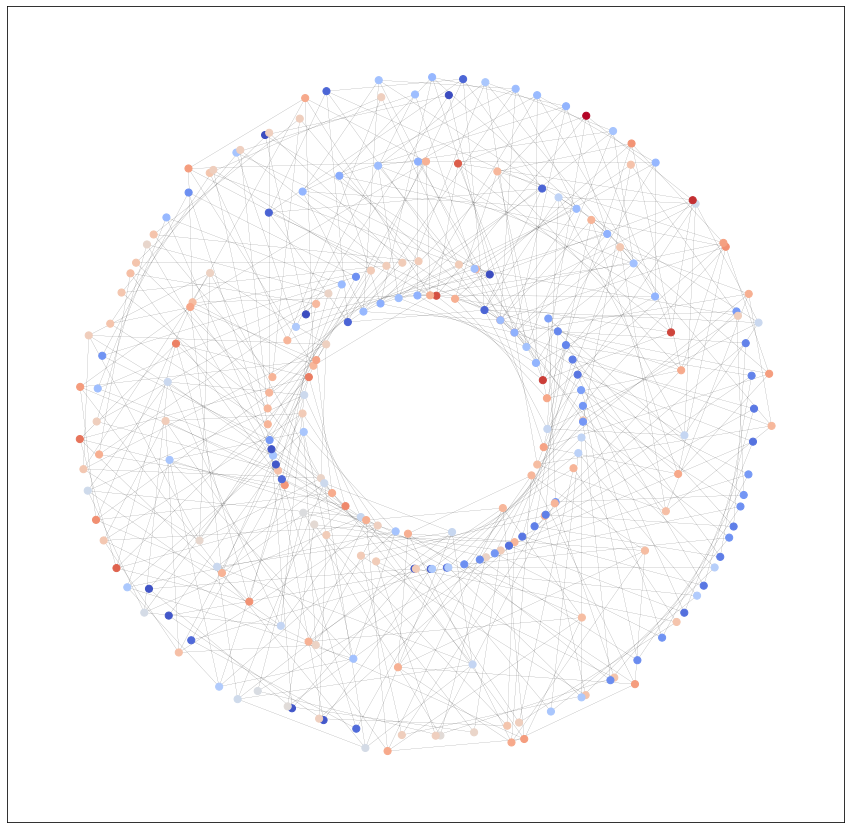

In [165]:
draw_graph(data.products.index,data.adjMatrix,data.edgeWeights,output[:,-1])

In [26]:
from torch_geometric.datasets import Planetoid

dataset = Planetoid(root='/tmp/Cora', name='Cora')

Processing...
Done!


In [30]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(dataset.num_node_features, 16)
        self.conv2 = GCNConv(16, dataset.num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        return F.log_softmax(x, dim=1)

In [31]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN().to(device)
data = dataset[0].to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

model.train()
for epoch in range(200):
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()


model.eval()
pred = model(data).argmax(dim=1)
correct = (pred[data.test_mask] == data.y[data.test_mask]).sum()
acc = int(correct) / int(data.test_mask.sum())
print(f'Accuracy: {acc:.4f}')

In [32]:
model.eval()
pred = model(data).argmax(dim=1)
correct = (pred[data.test_mask] == data.y[data.test_mask]).sum()
acc = int(correct) / int(data.test_mask.sum())
print(f'Accuracy: {acc:.4f}')

Accuracy: 0.8040
